# SOLUTION: Surname generation

In [2]:
import os

download_name = "surnames_with_splits.csv.bz2"
if not os.path.exists(download_name):
    import requests
    response = requests.get(f"https://raw.githubusercontent.com/bzitko/nlp_repo/main/assignments/a05/{download_name}")
    with open(download_name, "wb") as fp:
        fp.write(response.content)
    response.close()
        
name = "surnames_with_splits.csv"
if not os.path.exists(name):
    import bz2
    with open(download_name, 'rb') as bzf, open(name, 'wb') as fp:
        fp.write(bz2.decompress(bzf.read()))       

In [3]:
import os

import torch
import torch.nn.functional as F

from argparse import Namespace
from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings

In [4]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    model_filename="model.pth",
    # Model hyper parameter
    surname_embedding_size=32,
    nationality_hidden_size=32,
    # Training hyper parameter
    num_epochs=100,
    learning_rate=0.001,
    batch_size=128,
    seed=1337,
    early_stop=10,
    # Runtime hyper parameter
)

args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reading

In [5]:
df = pd.read_csv(args.surname_csv).drop(["nationality_index"], axis=1)
df


,nationality,split,surname
0,Arabic,train,Totah
1,Arabic,train,Abboud
2,Arabic,train,Fakhoury
3,Arabic,train,Srour
4,Arabic,train,Sayegh
...,...,...,...
10975,Vietnamese,test,Dinh
10976,Vietnamese,test,Phung
10977,Vietnamese,test,Quang
10978,Vietnamese,test,Vu


## Vocabulary

Generalized vocabulary can have:
* padding token - to fill up empty space
* unknown token - token for out-of-vocabulary tokens
* begin sequence - token for start of a sequence
* end sequence - token for end of a sequence


In [6]:
class Vocab(object):

    def __init__(self, tokens=None, pad_token=None, unk_token=None, begin_seq_token=None, end_seq_token=None):
        self._tok2idx = {}
        self._idx2tok = {}
        
        self.pad_token = pad_token
        self.pad_idx = None
        if pad_token is not None:
            self.pad_idx = self.add_token(pad_token)
        
        self.unk_token = unk_token
        self.unk_idx = None
        if unk_token is not None:
            self.unk_idx = self.add_token(unk_token)

        self.begin_seq_token = begin_seq_token
        self.begin_seq_idx = None
        if begin_seq_token is not None:
            self.begin_seq_idx = self.add_token(begin_seq_token)

        self.end_seq_token = end_seq_token
        self.end_seq_idx = None
        if end_seq_token is not None:
            self.end_seq_idx = self.add_token(end_seq_token)

        if tokens is not None:
            self.add_tokens(tokens)

    def add_token(self, token):
        if token not in self._tok2idx:
            idx = len(self._tok2idx)
            self._tok2idx[token] = idx
            self._idx2tok[idx] = token
            return idx
        return self._tok2idx[token]

    def add_tokens(self, tokens):
        return [self.add_token(token) for token in tokens]

    def ordered_indices(self):
        return sorted(self._idx2tok)

    def ordered_tokens(self):
        for i in sorted(self._idx2tok):
            yield self._idx2tok[i]

    def __getitem__(self, token_or_idx):
        if isinstance(token_or_idx, str):
            return self._tok2idx.get(token_or_idx, self.unk_idx)
        if isinstance(token_or_idx, int):
            return self._idx2tok.get(token_or_idx, self.unk_token)

    def __len__(self):
        return len(self._tok2idx)

    def __iter__(self):
        for i in sorted(self._idx2tok):
            yield self._idx2tok[i]

    def info(self):
        txt = f"Vocabulary size:{len(self)}"
        for i in range(min(4, len(self))):
            txt += f" {self[i]}:{i}"
        txt += " ..."
        print(txt)

chars = {ch for surname in df[df.split == "train"].surname for ch in surname}
surname_vocab = Vocab(sorted(chars), pad_token=".", unk_token="@", begin_seq_token="<", end_seq_token=">")
nationality_vocab = Vocab(sorted(df.nationality))



## Vectorizer

* `vectorizer(tokens)` should return long tensor (vector). Vector values corresponds to tokens. Vector should be filled with padding indexes to satisfy vector maximal size.  

* 👍  method `vectorize(tokens, seq=True)` receives 
    * `tokens` - a list of vocabulary entities, and
    * `seq` - if set to true, then resulting vector represents a sequence.

Let 0 is padding index, 2 is begin of sequence index and 3 is end of sequence index and maximal size is 10. Then for tokens whose indices are, for example, 56, 96 41, a resulting vector should be `[2 56 96 41 3 0 0 0 0]`.  
If `seq` is set to false, resulting vector should be `[56 96 41 0 0 0 0 0 0]`.

In [8]:
class Vectorizer():

    def __init__(self, vocabulary, max_size=-1):
        self.vocab = vocabulary
        self.max_size = max_size

    def vectorize(self, tokens, seq=True):
        indices = [self.vocab[tok] for tok in tokens]
        if seq:
            indices = [self.vocab.begin_seq_idx] + indices + [self.vocab.end_seq_idx]
            
        if self.max_size >= 0:
            indices = indices[:self.max_size]
            indices += [self.vocab.pad_idx] * (self.max_size - len(indices))
        return torch.LongTensor(indices)    


surname_max_size = max(len(surname) for surname in df.surname)
surname_vectorizer = Vectorizer(surname_vocab, surname_max_size + 2)
nationality_vectorizer = Vectorizer(nationality_vocab)

assert nationality_vectorizer.vectorize(["English"], seq=False).tolist() == [4]
assert surname_vectorizer.vectorize("johnson", seq=True).tolist() == [ 2, 43, 48, 41, 47, 52, 48, 47,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0]

## Dataset

`SurnameDataset` class inherits `torch.utils.data.Dataset`.  
Implemented methods are:
* `__init__(df, vectorizer_x, vectorizer_h, nationalities)` initialization receives dataframe `df`, `vectorizer_x` vectorizer for surnames, and `vectorizer_h` for nationalities.
* `set_split()` for setting current data split
* 👍 `__getitem__(idx)` should return triple of vectors: x, y, h where 
    * x is vectorized surname, for example `[2 56 96 41 3 0 0 0 0]`
    * y is x moved to left, for example `[56 96 41 3 0 0 0 0 0]`
    * h is vector for nationality

    

In [14]:
class SurnameDataset(torch.utils.data.Dataset):

    def __init__(self, df, vectorizer_x, vectorizer_h, nationalities=None):
        if nationalities is None:
            self.df = df
        elif isinstance(nationalities, str):
            self.df = df[df.nationality == nationalities]
        else:
            self.df = df[df.nationality.isin(nationalities)]
        self.vectorizer_x = vectorizer_x
        self.vectorizer_h = vectorizer_h
        self._lookup = {split: self.df[self.df.split == split] for split in set(self.df.split)}
        self.set_split("train")
        
    def set_split(self, split):
        self._target_split = split
        self._target_df = self._lookup[split]

    def vectorize_x(self, surname):
        return self.vectorizer_x.vectorize(surname, seq=True)

    def vectorize_y(self, nationality):
        return self.vectorizer_h.vectorize([nationality], seq=False).squeeze()


    def frequency_x(self):
        return torch.tensor([len(self.df[self.df.surname==tok]) for tok in self.vectorizer_x.vocab.ordered_tokens()])

    def frequency_y(self):
        return torch.tensor([len(self.df[self.df.nationality==tok]) for tok in self.vectorizer_h.vocab.ordered_tokens()])

    def __getitem__(self, idx):
        item = self._target_df.iloc[idx]
        surname, nationality = item.surname, item.nationality
        indices_x = self.vectorizer_x.vectorize(surname, seq=True)
        indices_y = torch.cat([indices_x[1:], torch.zeros(1, dtype=torch.long)])
        index_h = self.vectorizer_h.vectorize([nationality], seq=False)
        return indices_x, indices_y, index_h
        
    def __len__(self):
        return len(self._target_df)

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True):
    for x1, x2, y in torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle):
        yield x1.to(args.device), x2.to(args.device), y.to(args.device)

dataset = SurnameDataset(df, surname_vectorizer, nationality_vectorizer)

assert len(dataset) == 7680
assert len(dataset[0]) == 3

dataset = SurnameDataset(df, surname_vectorizer, nationality_vectorizer, nationalities="English")
assert len(dataset) == 2080
assert len(dataset[0]) == 3

dataset = SurnameDataset(df, surname_vectorizer, nationality_vectorizer, nationalities="Russian")
assert len(dataset) == 1661
assert len(dataset[0]) == 3

dataset = SurnameDataset(df, surname_vectorizer, nationality_vectorizer, nationalities=["English", "Russian"])
assert len(dataset) == 3741
assert len(dataset[0]) == 3


dataset = SurnameDataset(df, surname_vectorizer, nationality_vectorizer)
x, y, h = dataset[0]
assert x.shape == y.shape
assert h.shape == (1,), h.shape
assert x.tolist() == [2, 27, 48, 53, 34, 41, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
assert y.tolist()[:-1] == x.tolist()[1:]

# Generator

👍  
`SurnameGenerator` initialization receives 
* `embedding_size` dimension of embedding vector (for surnames)
* `num_embeddings` size of surname vocabulary
* `rnn_hidden_size` dimension of hidden RNN layer
* `num_rnn_hidden_embedding` size of nationality vocabulary
* `dropout_p` probability of dropout

Model will consist of: 
* $E_s$ - embedding layer for surnames, 
* $E_n$ - embedding layer for nationalities,
* GRU - gated reccurent unit
* FC - fully connected layer with dropout

Forward receives 
* $x$ indicies of surnames
* $h$ indicies of nationalityes

then $\hat{y} = FC(GRU(E_s(x), E_n(h)))$.

Apply softmax if `apply_softmax` is set to true.


In [25]:
class SurnameGenerator(torch.nn.Module):
    def __init__(self, surname_embedding_size, num_surname_embeddings, 
                       nationality_embedding_size, num_nationality_embeddings=None, 
                       batch_first=True, padding_idx=0, dropout_p=0.5):
        super(SurnameGenerator, self).__init__()

        self.surname_emb = torch.nn.Embedding(num_embeddings=num_surname_embeddings,
                                              embedding_dim=surname_embedding_size,
                                              padding_idx=padding_idx)

        if num_nationality_embeddings:
            self.nationality_emb = torch.nn.Embedding(num_embeddings=num_nationality_embeddings,
                                                      embedding_dim=nationality_embedding_size)
        
        self.rnn = torch.nn.GRU(input_size=surname_embedding_size, 
                                hidden_size=nationality_embedding_size,
                                batch_first=batch_first)

        self.fc = torch.nn.Linear(in_features=nationality_embedding_size, 
                                  out_features=num_surname_embeddings)

        self.dropout_p = dropout_p


    def forward(self, x, h=None, apply_softmax=False):
        x_emb = self.surname_emb(x)
        h_emb = self.nationality_emb(h).permute(1, 0, 2) if h is not None else None
        
        y_hat, _ = self.rnn(x_emb, h_emb)

        batch_size, seq_size, feat_size = y_hat.shape
        #y_hat = y_hat.contiguous().view(batch_size * seq_size, feat_size)        

        y_hat = self.fc(F.dropout(y_hat, p=self.dropout_p))

        if apply_softmax:
            return F.softmax(y_hat, dim=-1)
    
        #new_feat_size = y_hat.shape[-1]
        #y_hat = y_hat.view(batch_size, seq_size, new_feat_size)

        #return y_hat
        return y_hat#.log_softmax(dim=-1)
        

generator = SurnameGenerator(surname_embedding_size=args.surname_embedding_size, 
                             num_surname_embeddings=len(dataset.vectorizer_x.vocab), 
                             nationality_embedding_size=args.nationality_hidden_size,
                             num_nationality_embeddings=len(dataset.vectorizer_h.vocab),
                             batch_first=True,
                             padding_idx=dataset.vectorizer_x.vocab.pad_idx)

x1, x2, h = next(generate_batches(dataset, batch_size=3))
y_hat = generator(x1)
assert y_hat.shape == (3, 19, 80)

y_hat = generator(x1, h)
assert y_hat.shape == (3, 19, 80)

## Settings

In [26]:
# accuracy
def compute_accuracy(y_hat, y):
    _, y_hat_indices = y_hat.max(dim=1)
    n_correct = torch.eq(y_hat_indices, y).sum().item()
    return n_correct / len(y_hat_indices) * 100

# early stopping
def early_stop(train_state, model):
    val_loss = train_state["val_loss"]
    if len(val_loss) < 2:
        torch.save(model.state_dict(), args.model_filename)
        return False
    
    if val_loss[-1] < val_loss[-2]:
        torch.save(model.state_dict(), args.model_filename)
    
    if len(val_loss) >= args.early_stop:
        val_loss =  val_loss[-args.early_stop:]
        return all(val_loss[i] < val_loss[i + 1] 
                   for i in range(args.early_stop - 1))

    return False

# Defining loss function

For 
* $N$ - batch size
* $S$ - sequence size
* $V$ - vocabulary size

$dim_S, dim_N$ are embedding dimensions for surnames and nationalities. 

* $E_S$ embeddings for surnames has $dim_S \times \ |V_S|$ dimension.
* $E_N$ embeddings for nationalities has $dim_N \times \ |V_N|$ dimension.

GRU input dimension is equal to $dim_S$ and hidden dimension is equal to $dim_N$.  
Let $h_t = \text{GRU}(x_t, h_{t-1})$




let $\hat{y}$ be a prediction tensor of shape $N \times C \times V$ and $y$ be a target tensor of shape $N \times C$.  
Function `compute_loss(y_hat, y)` is responsible for computing negative log-likelihood loss for each datapoint in the batch.

Before applying pyTorch's NLLLoss, each sequence in the batch $\hat{y}$ has to be turned into log of probabilities, i.e. $log(softmax(\hat{y}_i))$ for $i=1...N$. After calculating all $N$ losses by $NLLLoss(log(softmax(\hat{y}_i)), y_i)$ `compute_loss()` returns their mean.




In [27]:
loss_func = torch.nn.NLLLoss(ignore_index=0)

def compute_loss(y_hat, y):
    y_hat = F.log_softmax(y_hat, dim=-1)
    losses = []
    for b_y_hat, b_y in zip(y_hat, y):
        lv = loss_func(b_y_hat, b_y)
        losses.append(lv)
    return torch.stack(losses).mean()

batch_size = 3
seq_size = 2
vocab_size = 4

torch.manual_seed(42)
y_hat = torch.rand(batch_size, seq_size, vocab_size)
y = torch.tensor([[0, 1], [2, 1], [3, 0]])
loss = compute_loss(y_hat, y)
assert torch.all(loss == torch.tensor(1.33540785))


# Training loop

In [29]:
def compute_accuracy(y_hat, y):
    _, y_hat_indices = y_hat.max(dim=-1)
    y_hat_indices = y_hat_indices.ravel()
    y = y.ravel()
    n_correct = torch.eq(y_hat_indices, y).sum().item()
    return n_correct / len(y_hat_indices) * 100    

# generator

generator = SurnameGenerator(surname_embedding_size=args.surname_embedding_size, 
                             num_surname_embeddings=len(dataset.vectorizer_x.vocab), 
                             nationality_embedding_size=args.nationality_hidden_size,
                             num_nationality_embeddings=len(dataset.vectorizer_h.vocab),
                             batch_first=True,
                             padding_idx=dataset.vectorizer_x.vocab.pad_idx)

# seed
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

# loss, optimizer, scheduler
loss_func = torch.nn.NLLLoss(ignore_index=dataset.vectorizer_x.vocab.pad_idx)
optimizer = torch.optim.Adam(generator.parameters(), lr=args.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)

# progress bars
epoch_bar = tqdm(desc='epochs', total=args.num_epochs, position=0)
dataset.set_split('train')
train_bar = tqdm(desc='train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

# train state tracker
train_state = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": [],}


generator = generator.to(args.device)
try:
    for epoch_index in range(args.num_epochs):
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, batch_size=args.batch_size)
        running_loss = running_acc = 0.0
        
        generator.train()
        for batch_index, (x, y, h) in enumerate(batch_generator):
            optimizer.zero_grad()
            y_hat = generator(x, h)
            loss = compute_loss(y_hat, y)
            # loss = loss_func(y_hat, y)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            loss.backward()
            optimizer.step()

            acc_t = compute_accuracy(y_hat, y)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)        

        # Iterate over val dataset
        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, batch_size=args.batch_size)
        running_loss = running_acc = 0.0
        
        generator.eval()
        for batch_index, (x, y, h) in enumerate(batch_generator):
            y_hat =  generator(x, h)

            loss = compute_loss(y_hat, y)
            # loss = loss_func(y_hat, y)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_hat, y)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)   

        if early_stop(train_state, generator):
            print("Early stopping")
            break
        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

except KeyboardInterrupt:
    print("Exiting loop")


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

train:   0%|          | 0/60 [00:00<?, ?it/s]

val:   0%|          | 0/12 [00:00<?, ?it/s]

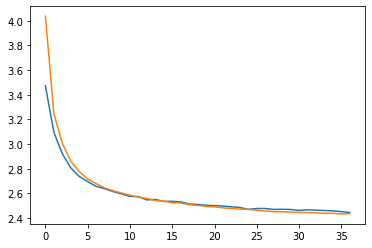

In [12]:
plt.plot(train_state["val_loss"])
plt.plot(train_state["train_loss"])

# Testing

In [13]:
generator.load_state_dict(torch.load(args.model_filename))

generator = generator.to(args.device)
loss_func = torch.nn.NLLLoss()

dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size=args.batch_size)

running_loss = 0.
running_acc = 0.

generator.eval()
for batch_index, (x, y, h) in enumerate(batch_generator):
    y_hat =  generator(x, h)
    
    # compute the loss
    loss = compute_loss(y_hat, y)
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_hat, y)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

print(f"Test loss: {running_loss:.4f}")
print(f"Test Accuracy: {running_acc:.4f}")

Test loss: 8.2533
Test Accuracy: 11.3492


## Sampling

Function `sample_from_model(model, vectorizer, num_samples=10, nationality_idx=None)` must generate `num_samples` surnames. If `nationality_idx` is set to some nationality index, then generated surnames belong to specific nationality. Nationality is represented as first hidden input $h_0$ to GRU.

In [14]:
def sample_from_model(model, vectorizer, num_samples=10, nationality_idx=None):
    # encode
    x_0 = torch.tensor([vectorizer.vocab.begin_seq_idx for _ in range(num_samples)])
    samples = [x_0]

    if nationality_idx:
        h = torch.tensor([nationality_idx for _ in range(num_samples)])
        h_t = model.hidden_emb(h).unsqueeze(0)
    else:
        h_t = None

    
    for t in range(vectorizer.max_size):
        x_t = samples[t].unsqueeze(1)
        x_emb = model.emb(x_t)
        y_t, h_t = model.rnn(x_emb, h_t)
        y_t = model.fc(y_t)

        pred = y_t.squeeze(1)
        prob = F.softmax(pred, dim=-1)
        indices = torch.multinomial(prob, num_samples=1).squeeze()
        samples.append(indices)
    
    samples = torch.stack(samples, dim=1)
    
    # decode
    surnames = []
    for sample in samples:
        surname = ""
        for num in sample.tolist():
            if num == vectorizer.vocab.begin_seq_idx:
                continue
            if num == vectorizer.vocab.end_seq_idx:
                break
            surname += vectorizer.vocab[num]
        surnames.append(surname)
    
    return surnames

for nationality in nationality_vocab:
    print(nationality)
    samples = sample_from_model(generator, surname_vectorizer, num_samples=3, nationality_idx=nationality_vocab[nationality])
    for sample in samples:
        print(" -", sample)

Arabic
 - Schhoz
 - Diamem
 - Aklrrilha
Chinese
 - Hue
 - Karn
 - Bar
Czech
 - Kvimen
 - Yusfonko
 - Hokibtan
Dutch
 - Bboad
 - Hatred
 - Trame
English
 - Lbags
 - Hiròn
 - Mihdo
French
 - Laclas
 - Foh
 - Rralg
German
 - Mura
 - Bias
 - Uràsr
Greek
 - Bamoshonka
 - Thediak
 - Tkensei
Irish
 - Smarot
 - Jitki
 - Dhantsov
Italian
 - Cidsatsi
 - Saltiig
 - Tod
Japanese
 - Khanaa
 - Adosta
 - Tusakuev
Korean
 - Heug
 - Sby
 - Sonesh
Polish
 - Qadov
 - Revko
 - Beula
Portuguese
 - Nanami
 - Barbimirla
 - Zadcson
Russian
 - Semichan
 - Tyago
 - Daninon
Scottish
 - Huluhsh
 - Muen
 - Kuwen
Spanish
 - Suema
 - Smaec
 - Cost
Vietnamese
 - Zou
 - Lor
 - Ter


# Misc

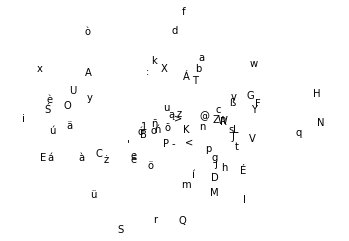

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')

emb = generator.emb.weight.data[1:,:]
labels = list(surname_vocab.ordered_tokens())[1:]
x = torch.tensor(pca.fit_transform(emb))


plt.axis("off")
plt.axis([torch.min(x).item(), torch.max(x).item(), torch.min(x).item(), torch.max(x).item()])
for (xi, yi), lbl in zip(x, labels):
    plt.text(xi, yi, lbl)